# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

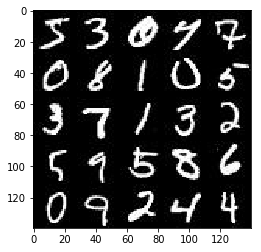

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

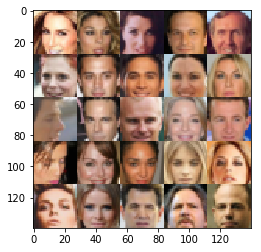

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/praveen.chaudhary/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return (input_real,input_z,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha=0.05
    
    with tf.variable_scope('discriminator',reuse=reuse):
        #Input Layer 28x28x3
        h1=tf.layers.conv2d(images,64,5,strides=2,padding='same')
        r1=tf.maximum(alpha*h1,h1)
        #16x16x32
        
        h2=tf.layers.conv2d(r1,128,5,strides=2,padding='same')
        bn2=tf.layers.batch_normalization(h2,training=True)
        r2=tf.maximum(alpha*bn2,bn2)
        #8x8x128
        
        h3=tf.layers.conv2d(r2,256,5,strides=2,padding='same')
        bn3=tf.layers.batch_normalization(h3,training=True)
        r3=tf.maximum(alpha*bn3,bn3)
        #4x4x256
        
        #Flattenning
        flat=tf.reshape(r3,(-1,4*4*256))
        logits=tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)      
                
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    print(z)
    alpha = 0.01
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        
        x2= tf.layers.conv2d_transpose(inputs=x1,filters=256,kernel_size=5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2,x2)
        
        x3= tf.layers.conv2d_transpose(inputs=x2,filters=128,kernel_size=5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3,x3)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same') 
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    
    input_real,input_z,lr= model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr=learning_rate
    
    d_loss, g_loss= model_loss(input_real, input_z, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples,losses=[],[]
    steps=0
    
    print_each=10
    show_each=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ =sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z})
                _=sess.run(g_opt,feed_dict={input_z:batch_z,input_real:batch_images})
              
                if steps % print_each == 0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))    
                    
                if steps % show_each == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)                  
                                                       
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                                                                                 
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("input_z:0", shape=(?, 100), dtype=float32)
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 20.5791
Epoch 1/2... Discriminator Loss: 1.7515... Generator Loss: 1.0694
Epoch 1/2... Discriminator Loss: 0.2386... Generator Loss: 3.0401
Epoch 1/2... Discriminator Loss: 0.0192... Generator Loss: 6.6598
Epoch 1/2... Discriminator Loss: 0.0074... Generator Loss: 6.2502
Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 5.4580
Epoch 1/2... Discriminator Loss: 0.0105... Generator Loss: 5.4267
Epoch 1/2... Discriminator Loss: 0.0052... Generator Loss: 6.0695
Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 7.1421
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.4649
Tensor("input_z:0", shape=(?, 100), dtype=float32)


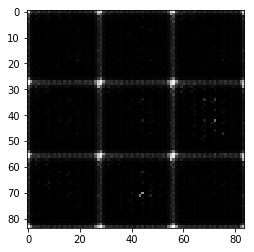

Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 6.7106
Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 7.6368
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 7.8631
Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 8.3500
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.5794
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 8.5492
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.1911
Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 1.1621
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 1.6189
Epoch 1/2... Discriminator Loss: 0.3117... Generator Loss: 3.0347
Tensor("input_z:0", shape=(?, 100), dtype=float32)


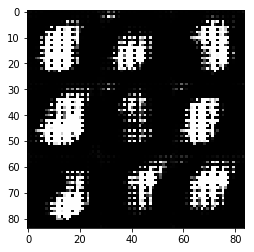

Epoch 1/2... Discriminator Loss: 0.3100... Generator Loss: 4.2641
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 2.2536... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 1.7067... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.4390
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 3.6604
Tensor("input_z:0", shape=(?, 100), dtype=float32)


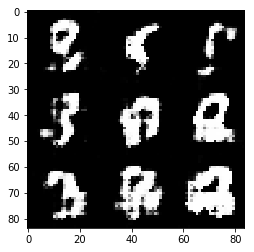

Epoch 1/2... Discriminator Loss: 0.3049... Generator Loss: 2.5709
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.8017... Generator Loss: 0.2896
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 2.3891
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 4.2232
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 1.4763
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 1.1227
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.6714
Tensor("input_z:0", shape=(?, 100), dtype=float32)


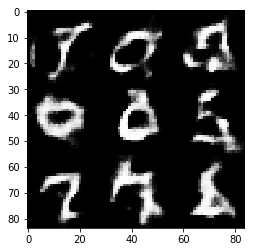

Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 0.3915
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 0.9894... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.5482
Tensor("input_z:0", shape=(?, 100), dtype=float32)


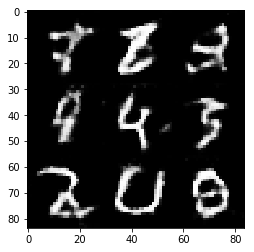

Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 1.3087
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.0319
Tensor("input_z:0", shape=(?, 100), dtype=float32)


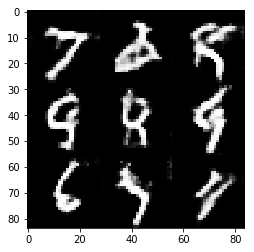

Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.1734
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.1721
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.9744
Tensor("input_z:0", shape=(?, 100), dtype=float32)


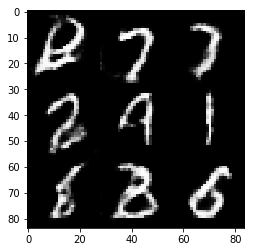

Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.4978
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.7000
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.6490... Generator Loss: 0.2896
Tensor("input_z:0", shape=(?, 100), dtype=float32)


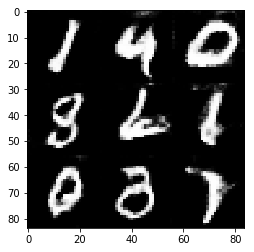

Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.4615
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 1.3198
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.8008
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.9174
Tensor("input_z:0", shape=(?, 100), dtype=float32)


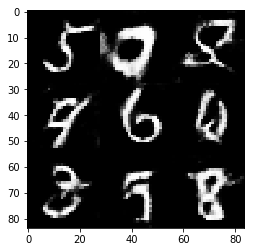

Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.4903
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 1.3065
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 1.2456
Tensor("input_z:0", shape=(?, 100), dtype=float32)


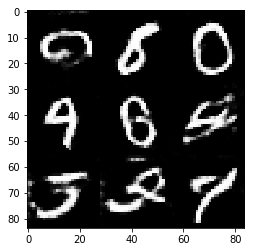

Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.9650
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.6173
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.6032
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.2200
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.6588
Tensor("input_z:0", shape=(?, 100), dtype=float32)


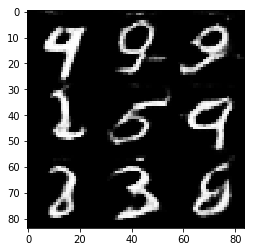

Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.2604
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.2894
Epoch 2/2... Discriminator Loss: 2.0089... Generator Loss: 0.2243
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 0.6193
Tensor("input_z:0", shape=(?, 100), dtype=float32)


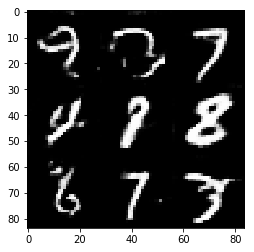

Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 1.2183
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.4859
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 1.4429
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 1.1336
Tensor("input_z:0", shape=(?, 100), dtype=float32)


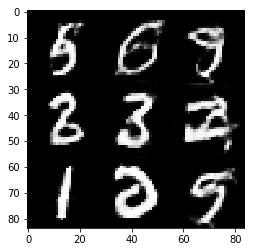

Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 1.7066
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.4497
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.4246
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.9893
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.6701
Tensor("input_z:0", shape=(?, 100), dtype=float32)


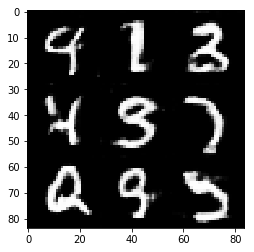

Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 0.3695
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 1.0992
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 2.1417
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 1.3869
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.7274
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.7791... Generator Loss: 0.2644
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.1236
Tensor("input_z:0", shape=(?, 100), dtype=float32)


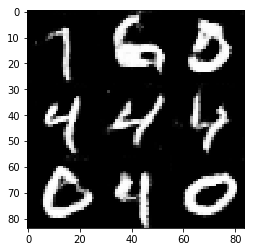

Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 1.6687
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 1.6445
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 1.2318
Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 1.0676... Generator Loss: 1.2658
Tensor("input_z:0", shape=(?, 100), dtype=float32)


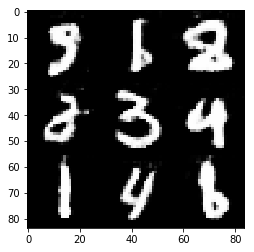

Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.5367
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 1.7332
Epoch 2/2... Discriminator Loss: 1.2215... Generator Loss: 0.5664
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.3973
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 1.5392... Generator Loss: 0.3406
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.4329
Tensor("input_z:0", shape=(?, 100), dtype=float32)


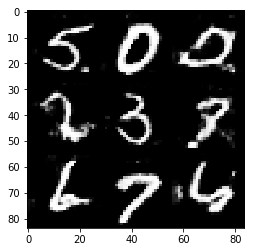

Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.4927
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 2.2365
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.4927
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.5685
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.6576
Tensor("input_z:0", shape=(?, 100), dtype=float32)


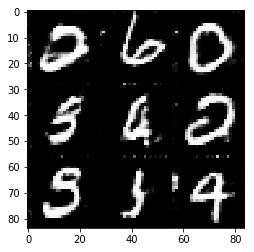

Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6258
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 1.2136
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 1.0532
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 1.4224
Tensor("input_z:0", shape=(?, 100), dtype=float32)


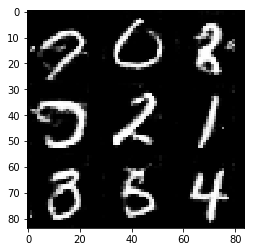

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("input_z:0", shape=(?, 100), dtype=float32)
Epoch 1/2... Discriminator Loss: 0.0026... Generator Loss: 7.7551
Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 11.0926
Epoch 1/2... Discriminator Loss: 0.0499... Generator Loss: 16.7144
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 12.6010
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 10.6338
Epoch 1/2... Discriminator Loss: 0.0031... Generator Loss: 6.9070
Epoch 1/2... Discriminator Loss: 1.5299... Generator Loss: 2.2675
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 3.0726
Epoch 1/2... Discriminator Loss: 2.6800... Generator Loss: 0.2089
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 1.0053
Tensor("input_z:0", shape=(?, 100), dtype=float32)


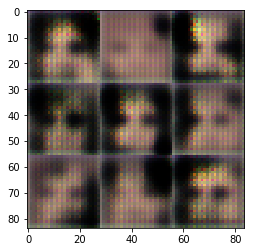

Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.4472
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.9004... Generator Loss: 0.2407
Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.4836
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6590
Tensor("input_z:0", shape=(?, 100), dtype=float32)


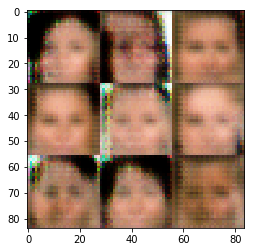

Epoch 1/2... Discriminator Loss: 2.2310... Generator Loss: 0.1274
Epoch 1/2... Discriminator Loss: 2.2641... Generator Loss: 0.1489
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 1.8721... Generator Loss: 0.2462
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.6325
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.5734
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.1770
Tensor("input_z:0", shape=(?, 100), dtype=float32)


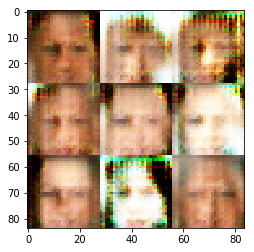

Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 1.5764
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 1.5358
Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 1.3655
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 2.0748... Generator Loss: 2.5360
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.8827
Tensor("input_z:0", shape=(?, 100), dtype=float32)


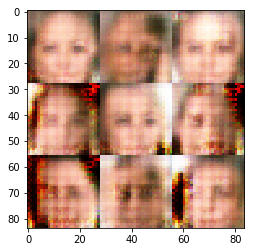

Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.6659
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.7491
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 1.2002
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 1.0781
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 1.3480
Tensor("input_z:0", shape=(?, 100), dtype=float32)


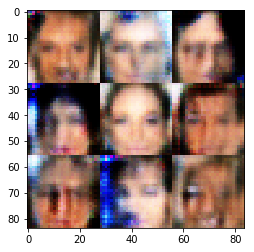

Epoch 1/2... Discriminator Loss: 1.7202... Generator Loss: 0.2658
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 1.3416
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.5218
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.5922
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 1.2340
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.5759
Tensor("input_z:0", shape=(?, 100), dtype=float32)


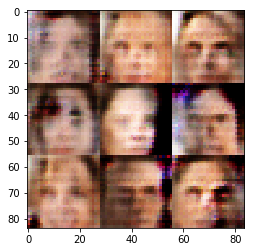

Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.2551
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.4383
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.4648
Tensor("input_z:0", shape=(?, 100), dtype=float32)


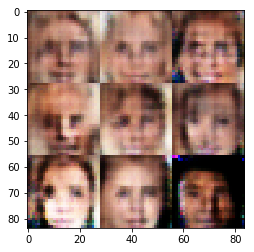

Epoch 1/2... Discriminator Loss: 1.8743... Generator Loss: 1.7990
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 1.5917
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.4649
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 1.2465
Tensor("input_z:0", shape=(?, 100), dtype=float32)


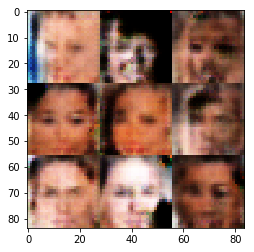

Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 1.0734
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.6207
Epoch 1/2... Discriminator Loss: 1.8552... Generator Loss: 0.2222
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.3896
Epoch 1/2... Discriminator Loss: 1.7858... Generator Loss: 0.2992
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.5179
Tensor("input_z:0", shape=(?, 100), dtype=float32)


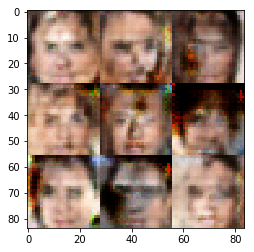

Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.0935
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.6893
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.4603
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.9470
Epoch 1/2... Discriminator Loss: 1.7310... Generator Loss: 0.3225
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.6861
Tensor("input_z:0", shape=(?, 100), dtype=float32)


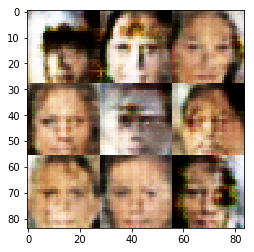

Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 1.2395
Epoch 1/2... Discriminator Loss: 2.1243... Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 1.2964
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.9178
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 2.6255... Generator Loss: 1.9173
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.8252
Tensor("input_z:0", shape=(?, 100), dtype=float32)


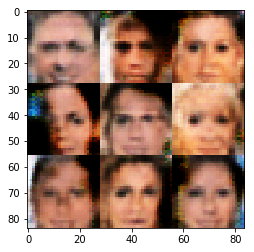

Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 1.2181
Tensor("input_z:0", shape=(?, 100), dtype=float32)


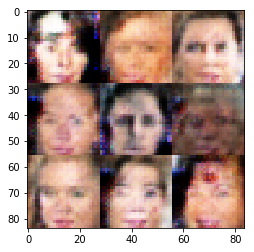

Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.8846
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 1.0131
Epoch 1/2... Discriminator Loss: 1.6483... Generator Loss: 1.5077
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.4829
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.4122
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.0734
Tensor("input_z:0", shape=(?, 100), dtype=float32)


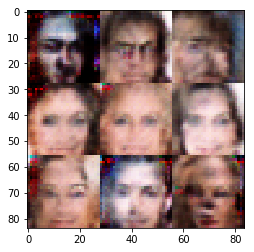

Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.7639
Tensor("input_z:0", shape=(?, 100), dtype=float32)


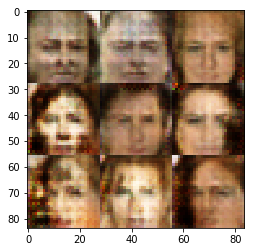

Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.8551
Tensor("input_z:0", shape=(?, 100), dtype=float32)


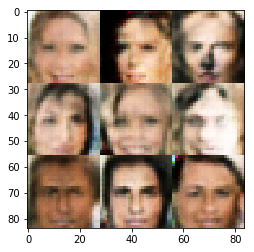

Epoch 1/2... Discriminator Loss: 1.5991... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.6501... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 0.5930
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.5058
Tensor("input_z:0", shape=(?, 100), dtype=float32)


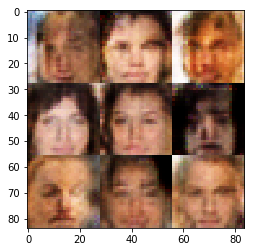

Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 1.0173
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.5220
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.7564
Tensor("input_z:0", shape=(?, 100), dtype=float32)


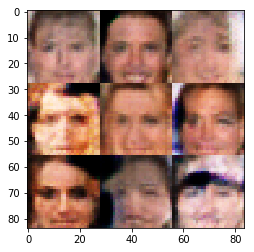

Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.3612
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.4285... Generator Loss: 0.5506
Tensor("input_z:0", shape=(?, 100), dtype=float32)


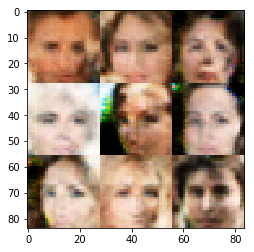

Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.8542
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.5645
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.9743
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.5752
Tensor("input_z:0", shape=(?, 100), dtype=float32)


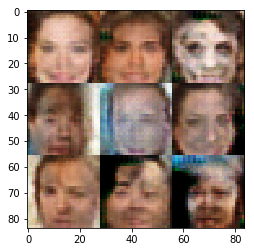

Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 1.0114
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.7276
Tensor("input_z:0", shape=(?, 100), dtype=float32)


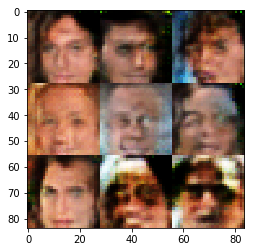

Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.6488... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.9302
Tensor("input_z:0", shape=(?, 100), dtype=float32)


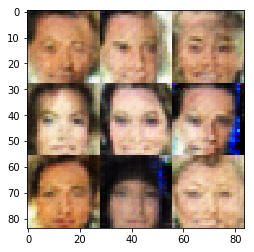

Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.5856
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.6217
Tensor("input_z:0", shape=(?, 100), dtype=float32)


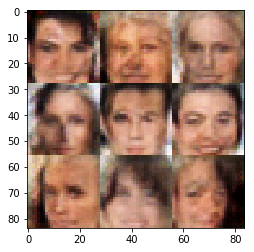

Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.6528
Tensor("input_z:0", shape=(?, 100), dtype=float32)


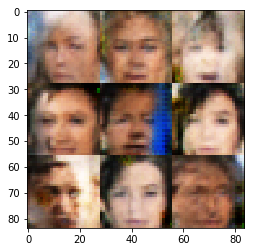

Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.8535
Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 1.2784... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.9817
Tensor("input_z:0", shape=(?, 100), dtype=float32)


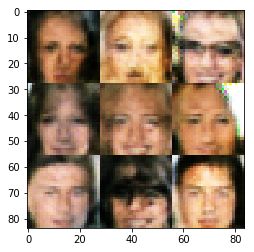

Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.5658
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 1.0132
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.5526
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.9126
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.6310... Generator Loss: 0.3801
Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.2899
Tensor("input_z:0", shape=(?, 100), dtype=float32)


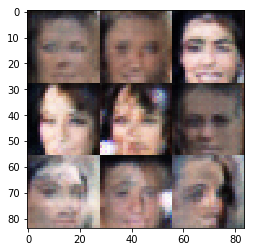

Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.0554
Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 1.8576... Generator Loss: 1.0122
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6777
Tensor("input_z:0", shape=(?, 100), dtype=float32)


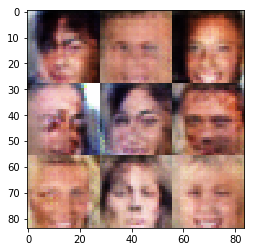

Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.5980
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.2024... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 1.2356
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.8366
Tensor("input_z:0", shape=(?, 100), dtype=float32)


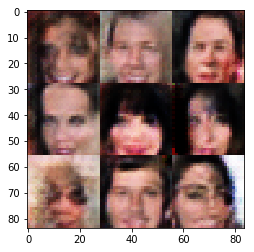

Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.4680
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.6711
Tensor("input_z:0", shape=(?, 100), dtype=float32)


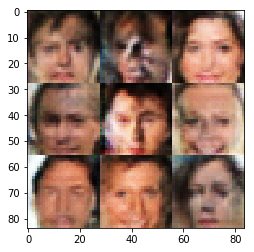

Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.5639
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.6291
Tensor("input_z:0", shape=(?, 100), dtype=float32)


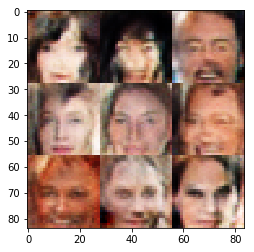

Epoch 1/2... Discriminator Loss: 1.5979... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.6164
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7183
Tensor("input_z:0", shape=(?, 100), dtype=float32)


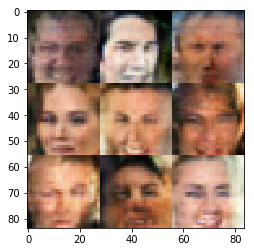

Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6185
Tensor("input_z:0", shape=(?, 100), dtype=float32)


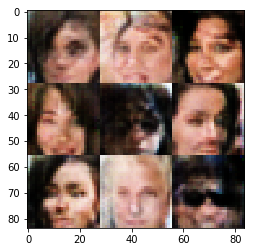

Epoch 1/2... Discriminator Loss: 1.6190... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.2341... Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.7689
Tensor("input_z:0", shape=(?, 100), dtype=float32)


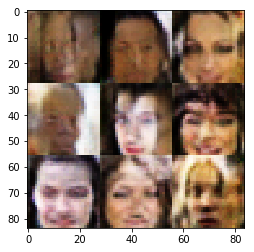

Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.4611... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.6180
Tensor("input_z:0", shape=(?, 100), dtype=float32)


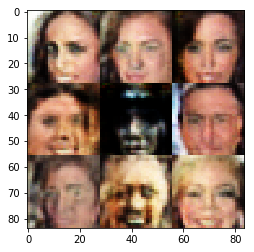

Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.5528
Epoch 2/2... Discriminator Loss: 1.5139... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.9136
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 1.4447... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.7054
Tensor("input_z:0", shape=(?, 100), dtype=float32)


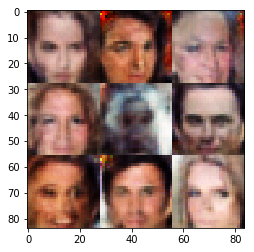

Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.5486
Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.8027
Tensor("input_z:0", shape=(?, 100), dtype=float32)


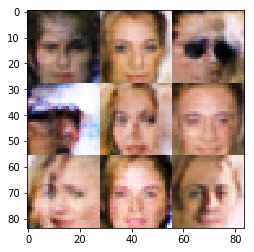

Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.7015
Tensor("input_z:0", shape=(?, 100), dtype=float32)


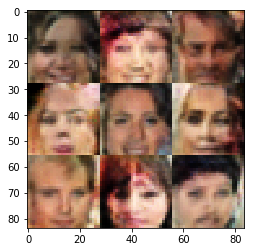

Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.6490
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.6870
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.4470
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7204
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 1.5653... Generator Loss: 0.8431
Tensor("input_z:0", shape=(?, 100), dtype=float32)


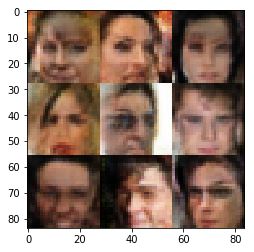

Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.6446
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.5597... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.4579
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.7265
Tensor("input_z:0", shape=(?, 100), dtype=float32)


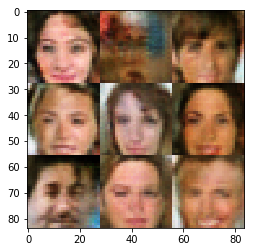

Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.6650
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.7571
Tensor("input_z:0", shape=(?, 100), dtype=float32)


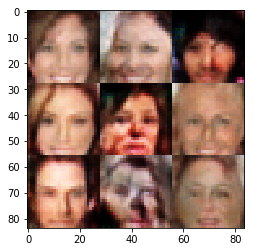

Epoch 2/2... Discriminator Loss: 1.4958... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.7206
Tensor("input_z:0", shape=(?, 100), dtype=float32)


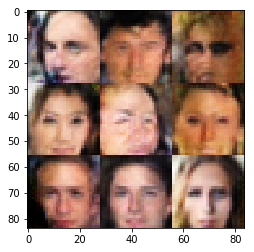

Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.6831
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.5242
Epoch 2/2... Discriminator Loss: 1.4654... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.8755
Tensor("input_z:0", shape=(?, 100), dtype=float32)


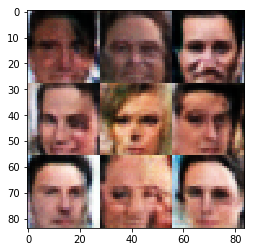

Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.5001... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.6236
Tensor("input_z:0", shape=(?, 100), dtype=float32)


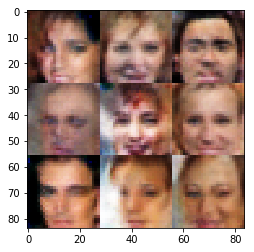

Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.7138
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.6687
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.7005
Tensor("input_z:0", shape=(?, 100), dtype=float32)


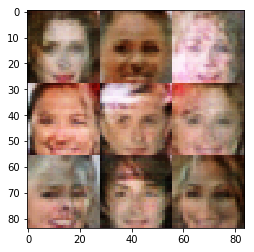

Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.6758
Epoch 2/2... Discriminator Loss: 1.4583... Generator Loss: 0.5777
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.5887
Tensor("input_z:0", shape=(?, 100), dtype=float32)


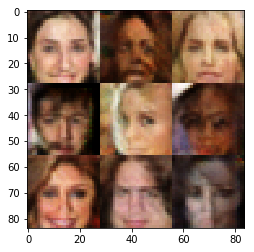

Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.5922
Tensor("input_z:0", shape=(?, 100), dtype=float32)


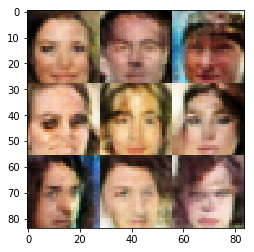

Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.6985
Epoch 2/2... Discriminator Loss: 1.5647... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.6333... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.5104
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.6871
Tensor("input_z:0", shape=(?, 100), dtype=float32)


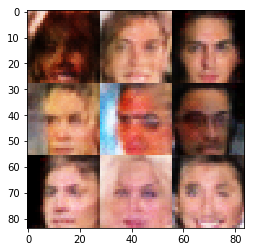

Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.8105
Tensor("input_z:0", shape=(?, 100), dtype=float32)


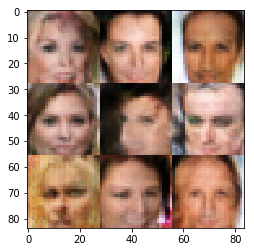

Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.6815
Tensor("input_z:0", shape=(?, 100), dtype=float32)


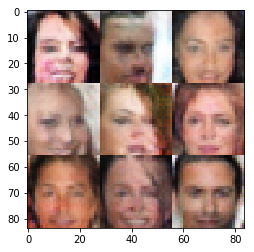

Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.5751... Generator Loss: 0.5566
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.5606... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.6153
Tensor("input_z:0", shape=(?, 100), dtype=float32)


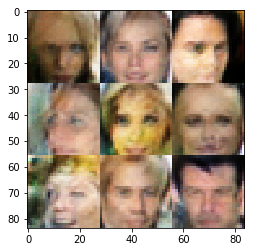

Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.5439
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.2215... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 0.6884
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.6632
Tensor("input_z:0", shape=(?, 100), dtype=float32)


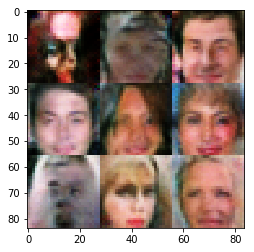

Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.5056... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.6318... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.7414
Tensor("input_z:0", shape=(?, 100), dtype=float32)


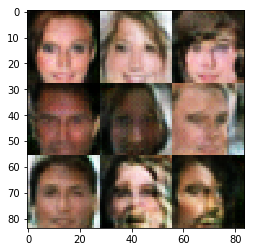

Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.8226


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.